<a href="https://colab.research.google.com/github/scarlightc39/composio/blob/master/EDA/EDA_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Package and Data Import

In [14]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [15]:
!mamba install -c conda-forge rdkit=2023.03.1


Looking for: ['rdkit=2023.03.1']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
Could not solve for environment specs
The following packages are incompatible
├─ libboost is installable with the potential options
│  ├─ libboost [1.84.0|1.85.0|1.86.0|1.87.0] would require
│  │  └─ icu >=75.1,<76.0a0 , which can be installed;
│  ├─ libboost 1.82.0 would require
│  │  └─ icu >=72.1,<73.0a0 , which conflicts with any installable versions previously reported;
│  ├─ libboost 1.82.0 would require
│  │  └─ boost-cpp 1.82.0* , which can be installed;
│  ├─ libboost 1.83.0 would require
│  │  └─ boost-cpp 1.83.0* , which can be installed;
│  ├─ libboost 1.84.0 would require
│  │  ├─ boost-cpp 1.84.0* , which can be in

In [16]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

In [17]:
bioactivity_DF = pd.read_csv('https://raw.githubusercontent.com/mehdimerbah/CompDrugDiscovery/main/data/preprocessed_bioactivity_data.csv')
bioactivity_DF.head()

,molecule_chembl_id,canonical_smiles,standard_value,activity_class
0,CHEMBL372889,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C(N)=O)ccc21,25.0,active
1,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,moderate
2,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,moderate
3,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
4,CHEMBL188484,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc(I)cc21,13.0,active


## Calculating Descriptors

### Defining a Lipinski Descriptors Function

In [18]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors


In [19]:
lipinski_data = lipinski(bioactivity_DF.canonical_smiles)
lipinski_data.head()

,MW,LogP,NumHDonors,NumHAcceptors
0,299.286,1.11984,1.0,5.0
1,281.271,1.89262,0.0,5.0
2,415.589,3.81320,0.0,2.0
3,421.190,2.66050,0.0,4.0
4,403.175,3.76690,0.0,3.0


In [20]:
final_DF = pd.concat([bioactivity_DF, lipinski_data], axis = 1)
final_DF.shape
final_DF.head()

,molecule_chembl_id,canonical_smiles,standard_value,activity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL372889,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C(N)=O)ccc21,25.0,active,299.286,1.11984,1.0,5.0
1,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,moderate,281.271,1.89262,0.0,5.0
2,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,moderate,415.589,3.81320,0.0,2.0
3,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive,421.190,2.66050,0.0,4.0
4,CHEMBL188484,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc(I)cc21,13.0,active,403.175,3.76690,0.0,3.0


### Logarithmic Normalization
The activity data distribution is highly skewed as some molecules are highly 'inactive'. They do not relate to the biological activity process.

In [21]:
# Let's see the distribution description
bioactivity_DF.standard_value.describe()

,standard_value
count,2.870000e+02
mean,3.715624e+12
std,2.307431e+13
min,2.200000e-03
25%,2.500000e+01
50%,9.000000e+02
75%,2.500000e+04
max,3.311311e+14


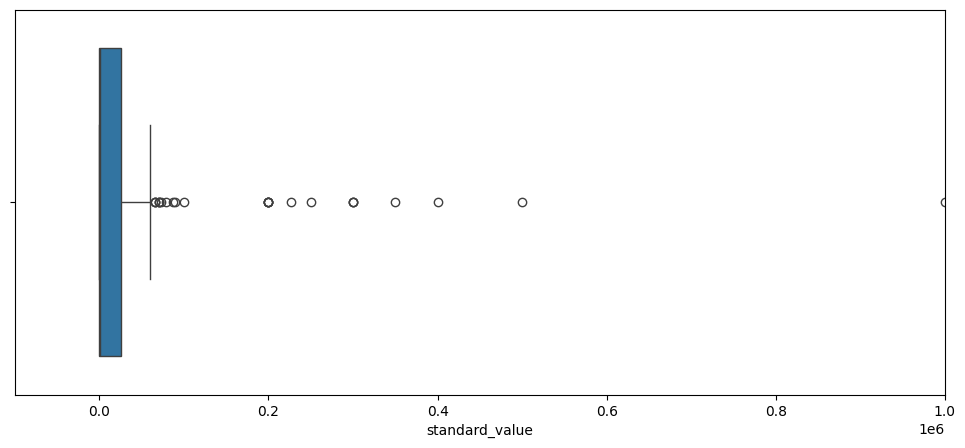

In [22]:
# The boxplot highlights the skewness
plt.figure(figsize=(12,5))
plt.xlim(-100000,1000000)
sns.boxplot(x=final_DF.standard_value)
plt.show()

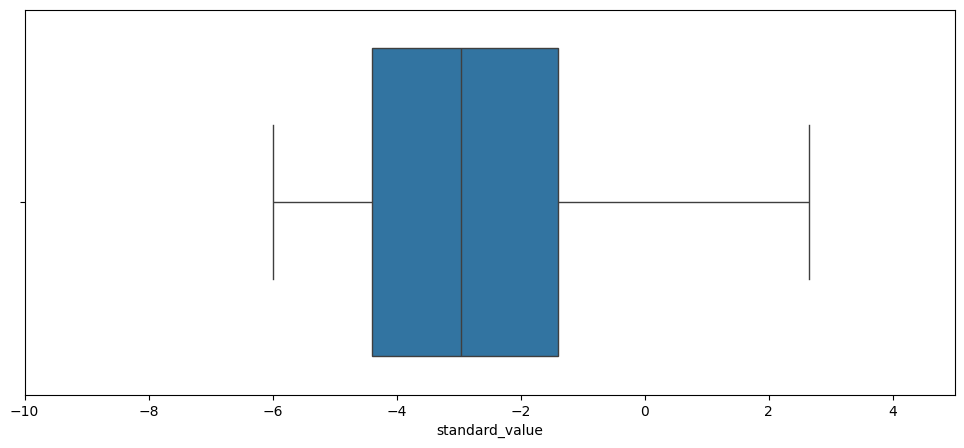

In [23]:
# We can see how log10 normalization would affect the data distribution
plt.figure(figsize=(12,5))
plt.xlim(-10,5)
sns.boxplot(x=-np.log10(final_DF.standard_value))
plt.show()

In [24]:
# First let's cap the values
norm = []
for i in final_DF['standard_value']:
  if i > 100000000:
    i = 100000000
  norm.append(i)

# Rename the activity values to pIC50 (nomalized values for the IC50 activity data)
final_DF['pIC50'] = norm
final_DF = final_DF.drop(columns=['standard_value'])
final_DF.shape
final_DF.head(5)


,molecule_chembl_id,canonical_smiles,activity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL372889,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C(N)=O)ccc21,active,299.286,1.11984,1.0,5.0,25.0
1,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,moderate,281.271,1.89262,0.0,5.0,7200.0
2,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,moderate,415.589,3.81320,0.0,2.0,9400.0
3,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.0
4,CHEMBL188484,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc(I)cc21,active,403.175,3.76690,0.0,3.0,13.0


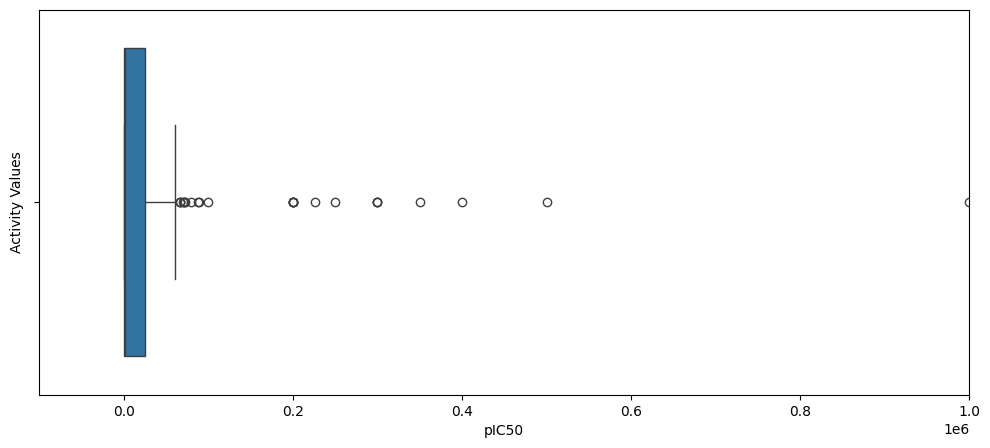

In [25]:
# Let's look at the data distribution again to make sure we did not change anything so far
plt.figure(figsize=(12,5))
plt.xlim(-100000,1000000)
plt.ylabel('Activity Values')
sns.boxplot(x = final_DF.pIC50)
plt.show()

In [26]:
# Now we can normalize the values
final_DF['pIC50'] = final_DF['pIC50']*(10**-9)

In [27]:
final_DF.head(10)

,molecule_chembl_id,canonical_smiles,activity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL372889,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C(N)=O)ccc21,active,299.286,1.11984,1.0,5.0,2.500000e-08
1,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,moderate,281.271,1.89262,0.0,5.0,7.200000e-06
2,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,moderate,415.589,3.81320,0.0,2.0,9.400000e-06
3,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,1.350000e-05
4,CHEMBL188484,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc(I)cc21,active,403.175,3.76690,0.0,3.0,1.300000e-08
5,CHEMBL362781,COc1ccc2c(c1)C(=O)C(=O)N2Cc1cc2ccccc2o1,active,307.305,3.17090,0.0,4.0,1.300000e-08
6,CHEMBL191322,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc([N+](=O)[O-])cc21,active,322.276,3.07050,0.0,5.0,2.400000e-08
7,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,1.311000e-05
8,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],moderate,338.344,3.53900,0.0,5.0,2.000000e-06
9,CHEMBL363243,Nc1cccc2c1N(Cc1cc3ccccc3s1)C(=O)C2=O,active,308.362,3.21300,1.0,4.0,3.100000e-08


In [28]:
final_DF['pIC50'] = -np.log10(final_DF['pIC50'])
final_DF.head(10)

,molecule_chembl_id,canonical_smiles,activity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL372889,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C(N)=O)ccc21,active,299.286,1.11984,1.0,5.0,7.602060
1,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,moderate,281.271,1.89262,0.0,5.0,5.142668
2,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,moderate,415.589,3.81320,0.0,2.0,5.026872
3,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
4,CHEMBL188484,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc(I)cc21,active,403.175,3.76690,0.0,3.0,7.886057
5,CHEMBL362781,COc1ccc2c(c1)C(=O)C(=O)N2Cc1cc2ccccc2o1,active,307.305,3.17090,0.0,4.0,7.886057
6,CHEMBL191322,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc([N+](=O)[O-])cc21,active,322.276,3.07050,0.0,5.0,7.619789
7,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
8,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],moderate,338.344,3.53900,0.0,5.0,5.698970
9,CHEMBL363243,Nc1cccc2c1N(Cc1cc3ccccc3s1)C(=O)C2=O,active,308.362,3.21300,1.0,4.0,7.508638


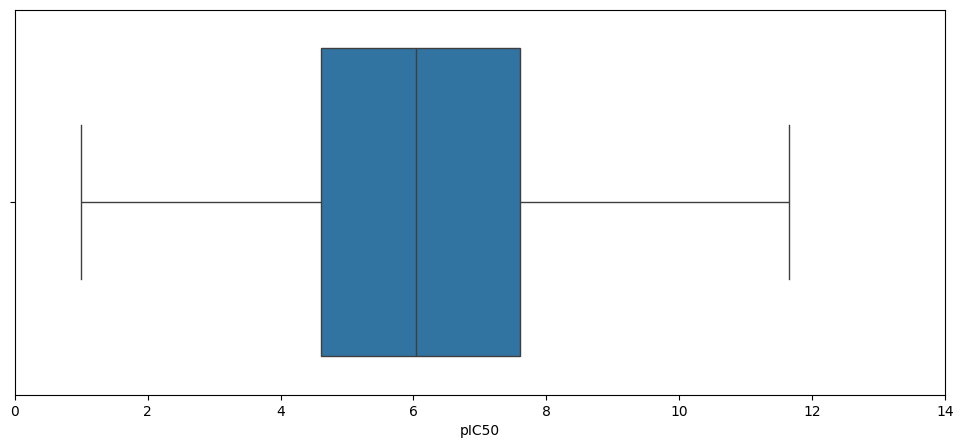

In [29]:
# Now we can plot the normalized values to see how they have changed.
plt.figure(figsize=(12,5))
plt.xlim(0,14)
sns.boxplot(x = final_DF.pIC50)
plt.show()

In [30]:
# Let's get the data description too
final_DF.to_csv("normalized_data.csv", index =  False)
final_DF.pIC50.describe()

,pIC50
count,287.000000
mean,5.791977
std,2.219237
min,1.000000
25%,4.602060
50%,6.045757
75%,7.602060
max,11.657577


# Eexploratory Data Analysis

## Class Distributions

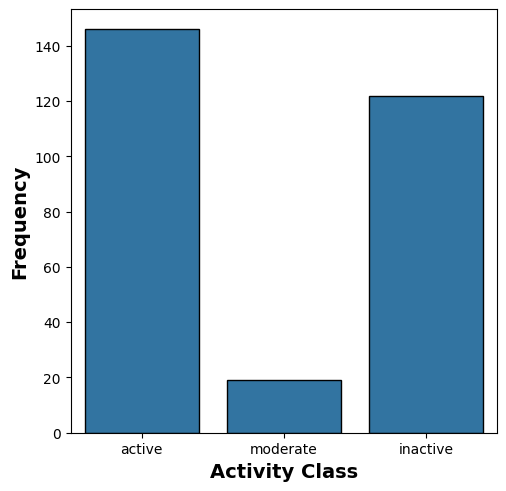

In [31]:
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='activity_class', data=final_DF, edgecolor='black')
plt.xlabel('Activity Class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('plot_bioactivity_3_classes.png')

Let's focus on active and inactive classes and drop the moderate activity class.

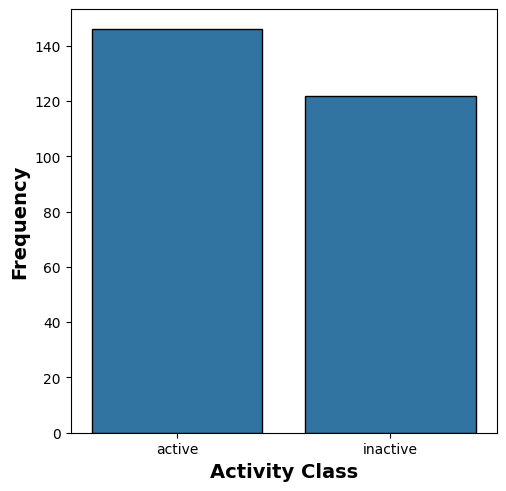

In [32]:
# Drop the moderate class
final_DF = final_DF[final_DF.activity_class != 'moderate']

# Let's plot again
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='activity_class', data=final_DF, edgecolor='black')
plt.xlabel('Activity Class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('plot_bioactivity_2_classes.png')


## MW vs logP Scatter Plot

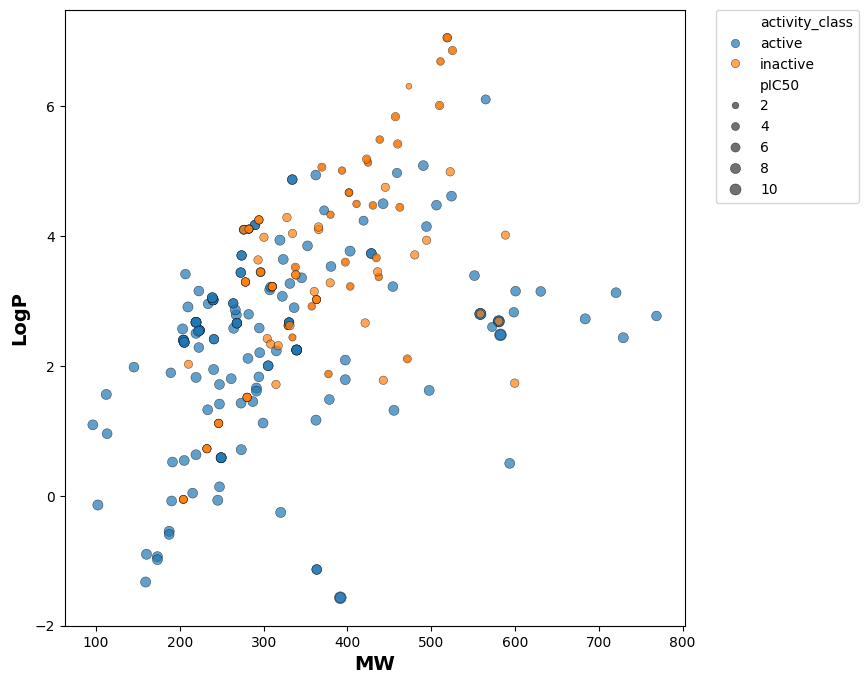

In [33]:
# Plot again
plt.figure(figsize=(8, 8))
sns.scatterplot(x='MW', y='LogP', data=final_DF, hue='activity_class', size='pIC50', edgecolor='black', alpha=0.7)
plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.png')

## Descriptor Distributions
Let's explore the distribution of pIC50 and the lipinski descriptors for each class.
### Mann–Whitney U Test
We will test any statsitically significant differences in the distributions between the two classes using a Mann-Whitnney U Test. So let's define a reusable function to get the relavnt test statistics and the Hypothesis verdict (reject H0 or fail to reject it, ie. are the distributions significantly different or are they the same).

In [34]:
def run_mannwhitney(descriptor):
  # set seed
  seed(1)

  ## Extract descriptor data from the dataframe
  ### Active
  active_molecules = final_DF[[descriptor, 'activity_class']]
  active_molecules = active_molecules[active_molecules.activity_class == 'active']
  active_molecules = active_molecules[descriptor]
  ### Inactive
  inactive_molecules = final_DF[[descriptor, 'activity_class']]
  inactive_molecules = inactive_molecules[inactive_molecules.activity_class == 'inactive']
  inactive_molecules = inactive_molecules[descriptor]

  ## Run mannwhitney u test
  stats, pvalue = mannwhitneyu(active_molecules, inactive_molecules)

  ## store results

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stats,
                          'p-value':pvalue
                          }, index=[0])

  filename = 'mannwhitneyu_' + descriptor + '.csv'

  results.to_csv(filename)

  return results


### Boxplots for Distributions
Let's get the boxplots for each of the descriptors for both classes.

In [35]:
# Let's just define a function we oculd reuse for the boxplots

def get_boxplot(descriptor):
  plt.figure(figsize=(8, 8))
  sns.boxplot(x = 'activity_class', y = descriptor, data = final_DF)
  plt.xlabel('Activity Class', fontsize=14, fontweight='bold')
  plt.ylabel(descriptor, fontsize=14, fontweight='bold')
  plot_title = descriptor + 'boxplot_binary_class.png'
  plt.savefig(plot_title)

**pIC50**

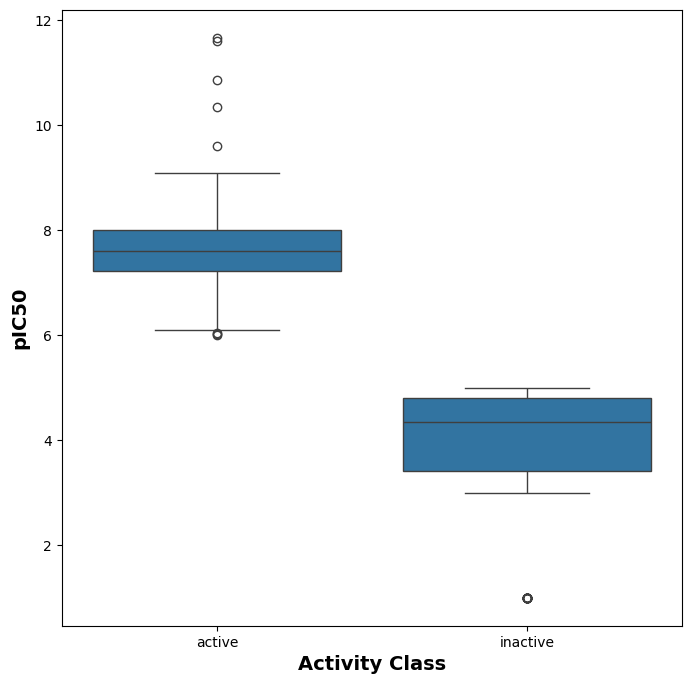

In [36]:
get_boxplot('pIC50')

In [37]:
run_mannwhitney('pIC50')

,Descriptor,Statistics,p-value
0,pIC50,17812.0,3.016919e-45


**MW**

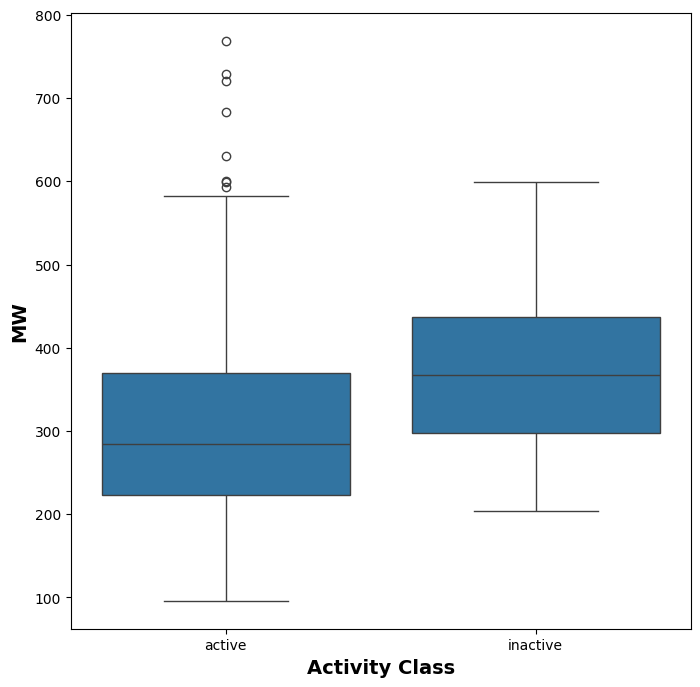

In [38]:
get_boxplot('MW')

In [39]:
run_mannwhitney('MW')

,Descriptor,Statistics,p-value
0,MW,5657.0,2.731756e-07


**LogP**

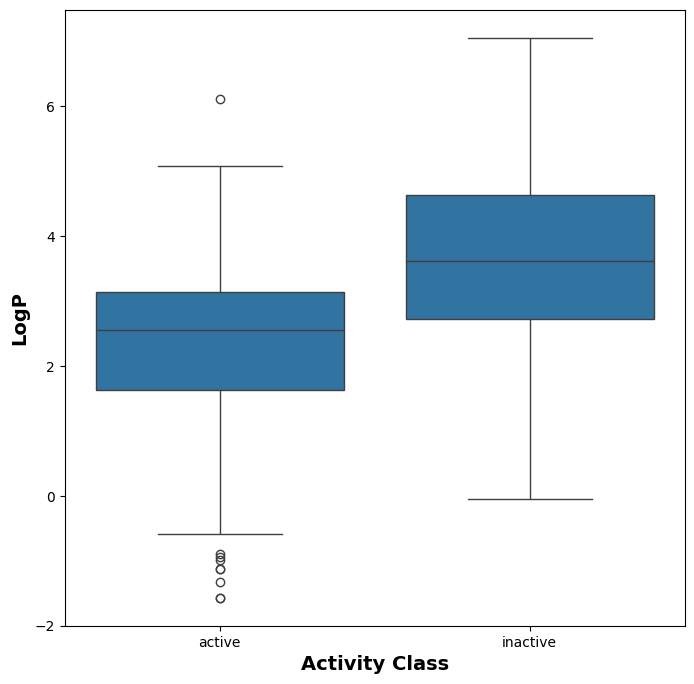

In [40]:
get_boxplot('LogP')

In [41]:
run_mannwhitney('LogP')

,Descriptor,Statistics,p-value
0,LogP,4503.0,3.228558e-12


**Number of H Donors**

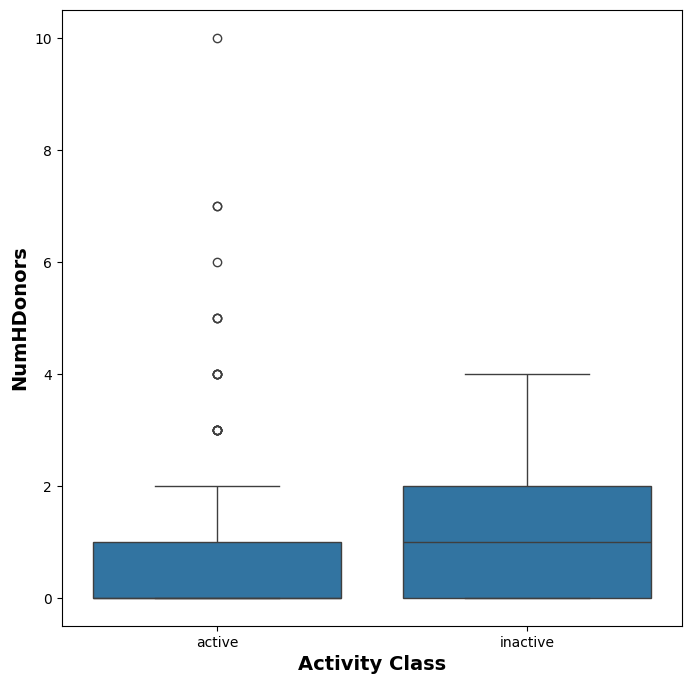

In [42]:
get_boxplot('NumHDonors')

In [43]:
run_mannwhitney('NumHDonors')

,Descriptor,Statistics,p-value
0,NumHDonors,7192.0,0.003851


**Number of H Acceptors**

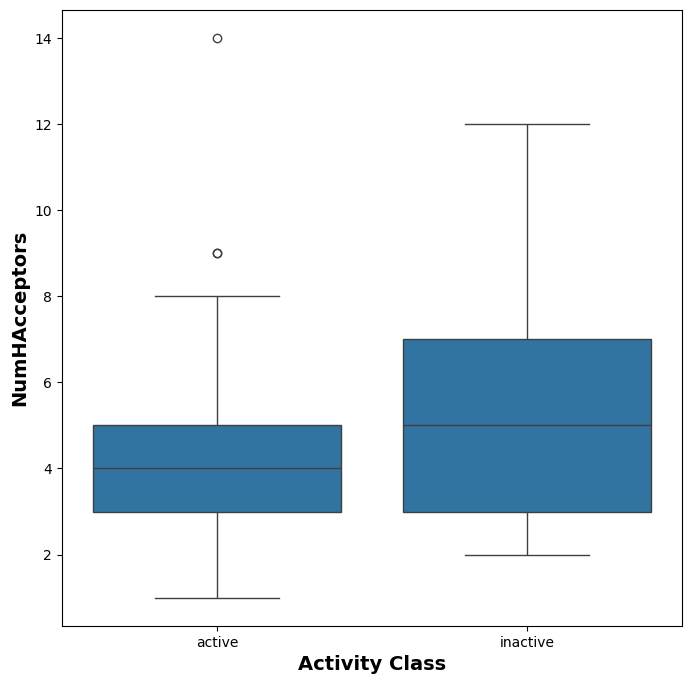

In [44]:
get_boxplot('NumHAcceptors')

In [45]:
run_mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p-value
0,NumHAcceptors,7489.0,0.022713
